In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.insert(0, "../zeolite-property-prediction/code/")
sys.path.insert(0, "../zeolite-property-prediction/")


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as tick

from tqdm import tqdm


from models.equivariant_mpnn import MPNNPORE
from utils.ZeoliteData import get_zeolite, get_data_pore
from utils.dataloading import get_data, get_graph_data, get_transform_matrix

In [2]:
import matplotlib as mpl

In [4]:
plt.rc('font', family='serif',)


In [5]:
from matplotlib import rc

In [6]:
data = get_zeolite('ITW', True)
    
ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell
ang = data['ang']

# specific for MOR
atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'ITW', ang)

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

In [7]:
_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, random=True)

In [8]:
trainX = trainloader.dataset.X.sum((1,2))[:,None].numpy()
trainy = trainloader.dataset.y[:,None].numpy()
testX = testloader.dataset.X.sum((1,2))[:,None].numpy()
testy = testloader.dataset.y[:,None].numpy()

In [9]:
from sklearn.linear_model import LinearRegression as LR

In [10]:
lr = LR()
lr.fit(trainX, trainy)

LinearRegression()

In [11]:
yhat = lr.predict(testX)

In [12]:
yhat.shape, testy.shape

((77, 1), (77, 1))

In [13]:
lr_mse, lr_mae = np.mean((testy - yhat)**2), np.mean(np.abs(testy - yhat))

In [14]:
lr_mse, lr_mae

(27.226569534500012, 3.510505944719408)

In [15]:
title_size=7.5
label_size=7

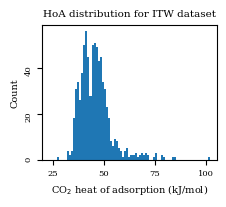

In [16]:
plt.figure(figsize=(2.25,1.75))
plt.hist(hoa, bins=np.arange(20,105,1))
plt.xlabel('CO$_2$ heat of adsorption (kJ/mol)', fontsize=label_size)
plt.ylabel('Count', fontsize=label_size)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6, rotation='vertical')
plt.title('HoA distribution for ITW dataset', fontsize=title_size)
plt.xlim(20,105)
plt.savefig('figures/datadist_itw.pdf', dpi=1200, bbox_inches="tight")
tikzz = plt.xticks()[0]

In [17]:
uniq = np.unique(atoms.sum(1))[1:]
np.where(uniq==3)[0][0]

2

In [18]:
hoa_x = np.tile(np.linspace(20,105,86)[:,None], (1,9))
hoa_y = np.tile(np.arange(0,9,1)[None], (hoa_x.shape[0],1))


In [19]:
hoa_x.shape

(86, 9)

In [20]:
uniq = np.unique(atoms.sum(1))[1:]

zi = np.zeros((len(hoa_x),9))

for i in range(len(atoms)):
    
    curr_h = hoa[i]
    
    _n_als = atoms[i].sum()
    if _n_als == 0:
        _n_als = 1

    n_als = np.where(uniq==_n_als)[0][0]
    # print(_n_als, n_als, curr_h)
    for _x in range(len(hoa_x)):
        # print(hoa_x[_x, n_als], curr_h)
        if hoa_x[_x, n_als] < curr_h <= hoa_x[_x+1, n_als]:
            # print('111')
            zi[_x, n_als] += 1

In [21]:
sum(zi > 0)

array([ 6, 10,  8, 12,  6, 13, 22, 24, 35])

In [22]:
zi = zi/zi.sum(0)[None]

In [23]:
uniq

array([ 1,  2,  3,  4,  5,  6,  8, 10, 12])

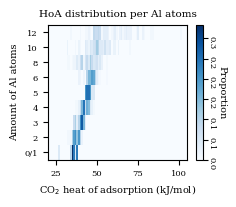

In [24]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
CS = plt.pcolormesh(hoa_x, hoa_y, zi,
                  vmax=zi.max(), vmin=0, cmap='Blues')

plt.xlabel(f"CO$_2$ heat of adsorption (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Amount of Al atoms", fontsize=label_size)
plt.title("HoA distribution per Al atoms", fontsize=title_size)
cbar = plt.colorbar()
plt.yticks(np.arange(0.,9,1), ['0/1',2,3,4,5,6,8,10,12], fontsize=6, rotation='horizontal')
plt.xticks(tikzz)
plt.xticks(fontsize=6)
plt.xlim(20,105)
plt.ylim(-0.5,8.5)
cbar.ax.tick_params(labelsize=6, rotation=270,pad=0)
cbar.ax.get_yaxis().labelpad = 8
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.set_label('Proportion', rotation=270, fontsize=label_size)
plt.savefig('figures/aldist_itw.pdf', dpi=1200, bbox_inches="tight")

In [25]:
hoa_x.shape, hoa_y.shape, zi.shape

((86, 9), (86, 9), (86, 9))

In [26]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True).to('cuda')

mpnn2 = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True, site_pred=True).to('cuda')

In [27]:
def get_95_CI(x):
    
    ci = 1.96*np.std(x)/np.sqrt(len(x))
    return ci

In [28]:
_mae_p = []
_mse_p = []


_mae_p2 = []
_mse_p2 = []

for j in tqdm(range(1,11)):

    mpnn.load_state_dict(torch.load(f'model_data_random/ITW/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn.predict(testloader)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    _mae_p.append(_mae)
    _mse_p.append(_mse)


    mpnn2.load_state_dict(torch.load(f'model_data_random2/ITW/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn2.predict(testloader)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    _mae_p2.append(_mae)
    _mse_p2.append(_mse)


mae_p  = np.mean(_mae_p)
mse_p = np.mean(_mse_p)
mae_p2  = np.mean(_mae_p2)
mse_p2 = np.mean(_mse_p2)


mae_p_ci = get_95_CI(_mae_p)
mse_p_ci = get_95_CI(_mse_p)
mae_p2_ci = get_95_CI(_mae_p2)
mse_p2_ci = get_95_CI(_mse_p2)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


In [29]:
mae_p, mae_p2, mse_p, mse_p2

(2.8571946144104006,
 2.5113800764083862,
 18.766975593566894,
 15.780515766143798)

In [30]:
mae_p_ci, mae_p2_ci, mse_p_ci, mse_p2_ci

(0.2693671227808544, 0.11625954720406104, 2.42133798960764, 1.0947356543420206)

In [31]:
best_idx = np.argmin(_mae_p)
mpnn2.load_state_dict(torch.load(f'model_data_random2/ITW/1.0/pore/model_{best_idx+1}/model.pth'))
y_pred, y_true = mpnn2.predict(testloader)

In [53]:
np.save('ats_itw.npy',testloader.dataset.X.numpy())

In [48]:
np.save('true_itw.npy', y_true.numpy())

In [39]:
from scipy.interpolate import griddata

In [40]:
y_pred.min(), y_pred.max(), y_true.min(), y_true.max()

(tensor(36.7324), tensor(67.2110), tensor(32.3122), tensor(74.0637))

In [41]:
Z = torch.ones_like(y_pred)

In [42]:
nn = 60
xmin = 30
xmax = 75
xi = np.linspace(xmin, xmax, nn)
yi = np.linspace(xmin, xmax, nn)

In [43]:
#xi.shape, yi.shape, xi, yi

In [44]:
zi = np.zeros((nn,nn))

for i in range(len(y_pred)):
    
    curr_p = y_pred[i].item()
    curr_t = y_true[i].item()
    
    for _x in range(0,nn-1):
        
        if xi[_x] < curr_p <= xi[_x+1]:
            
            for _y in range(0,nn-1):
                
                if yi[_y] < curr_t <= xi[_y+1]:
                    
                    zi[_x,_y] += 1

In [45]:
n_colors = int(zi.max())

C:\Users\20175552\AppData\Local\Temp\ipykernel_19300\4064518472.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues', n_colors+1)


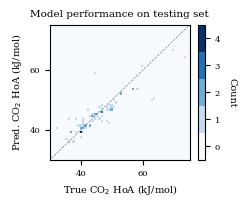

In [46]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
cmap = plt.cm.get_cmap('Blues', n_colors+1)
CS = plt.pcolormesh(xi, yi, zi,
                  vmax=zi.max(), vmin=0, cmap=cmap)
plt.xlabel(f"True CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Pred. CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.title("Model performance on testing set", fontsize=title_size)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".5", lw=.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 12
cbar.set_label('Count', rotation=270, fontsize=label_size)
cbar.ax.get_yaxis().set_ticks(np.arange(n_colors/(2*(n_colors+1)), n_colors, n_colors/(n_colors+1)), np.arange(n_colors+1) )
cbar.ax.tick_params(labelsize=6)
plt.xticks(plt.yticks()[0])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)

#plt.savefig('figures/truepred.svg', dpi=1200, bbox_inches="tight")
plt.savefig('figures/truepred_itw.pdf', dpi=1200, bbox_inches="tight")

In [25]:
h = get_transform_matrix(*l, *ang)

In [26]:
beta = 2*np.pi-np.radians(ang[1]) 

In [27]:
beta

4.439419485372777

In [28]:
# rotation_matrix = np.array([
#     [1, 0, 0],
#     [0, np.cos(beta), -np.sin(beta)],
#     [0, np.sin(beta), np.cos(beta)]
# ])

In [29]:
# rotation_matrix = np.array([
#     [np.cos(gamma), -np.sin(gamma), 0],
#     [np.sin(gamma), np.cos(gamma), 0],
#     [0, 0, 1]
# ])

In [30]:
beta=2.87

In [31]:
rotation_matrix = np.array([
    [np.cos(beta), 0, np.sin(beta)],
    [0, 1, 0],
    [-np.sin(beta), 0, np.cos(beta)]
])

In [32]:
_X = X @ rotation_matrix.T
_X_pore = X_pore @ rotation_matrix.T

In [33]:
#_X = X @ h
#_X = X[X[:,2]>0.5]

In [34]:
l

array([10.45 , 15.028,  8.954])

In [35]:
ang

array([ 90.  , 105.64,  90.  ])

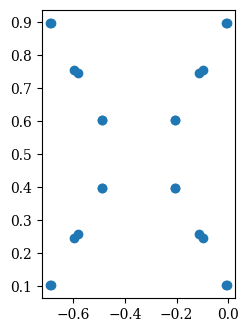

In [36]:
plt.figure(figsize=(10/4,15/4))
plt.scatter(_X[:,0], _X[:,1])

In [37]:
_X_pore = X_pore[:2]

In [38]:
color = np.zeros((X.shape[0],))
for i in range(len(X)):
    
    for j in range(3):
        
        for k in range(ref.shape[0]):
            
            if np.abs(X[i] - (np.mod(X[j]*ref[k] + tra[k], 1))).sum() < 0.1:
                
                color[i] = j
                
                break


color2 = np.zeros((_X_pore.shape[0],))
for i in range(len(_X_pore)):
    
    for j in range(5):
        
        for k in range(ref.shape[0]):
            
            if np.abs(_X_pore[i] - (np.mod(X_pore[j]*ref[k] + tra[k], 1))).sum() < 0.001:
                
                color2[i] = j
                
                break

In [39]:
color, color2

(array([0., 1., 2., 0., 1., 2., 0., 1., 2., 0., 1., 2., 0., 1., 2., 0., 1.,
        2., 0., 1., 2., 0., 1., 2.]),
 array([1., 1.]))

In [40]:
for k in range(len(ref)):
    print(np.mod(X[0]*ref[k] + tra[k], 1), X[k*3])
    print(np.mod(X[1]*ref[k] + tra[k], 1), X[k*3+1])
    print(np.mod(X[2]*ref[k] + tra[k], 1), X[k*3+2])

[0.352 0.244 0.894] [0.352 0.244 0.894]
[0.307 0.398 0.332] [0.307 0.398 0.332]
[0.404 0.398 0.686] [0.404 0.398 0.686]
[0.852 0.744 0.894] [0.648 0.244 0.106]
[0.807 0.898 0.332] [0.693 0.398 0.668]
[0.904 0.898 0.686] [0.596 0.398 0.314]
[0.648 0.244 0.106] [0.648 0.755 0.106]
[0.693 0.398 0.668] [0.693 0.602 0.668]
[0.596 0.398 0.314] [0.596 0.602 0.314]
[0.148 0.744 0.106] [0.352 0.755 0.894]
[0.193 0.898 0.668] [0.307 0.602 0.332]
[0.096 0.898 0.314] [0.404 0.602 0.686]
[0.648 0.756 0.106] [0.852 0.745 0.894]
[0.693 0.602 0.668] [0.807 0.898 0.332]
[0.596 0.602 0.314] [0.904 0.898 0.686]
[0.148 0.256 0.106] [0.148 0.745 0.106]
[0.193 0.102 0.668] [0.193 0.898 0.668]
[0.096 0.102 0.314] [0.096 0.898 0.314]
[0.352 0.756 0.894] [0.148 0.256 0.106]
[0.307 0.602 0.332] [0.193 0.102 0.668]
[0.404 0.602 0.686] [0.096 0.102 0.314]
[0.852 0.256 0.894] [0.852 0.256 0.894]
[0.807 0.102 0.332] [0.807 0.102 0.332]
[0.904 0.102 0.686] [0.904 0.102 0.686]


In [41]:
A_pore.sum(0)

array([24., 24., 16., 16.,  8.,  8., 12., 12.])

In [42]:
ce_dict = {}
row, col = np.nonzero(A)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in ce_dict:
        
        if added: break
        
        test = ce_dict[j][0]
        
        test_r = X[test[0]]
        test_c = X[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(X[r]*ref[k] + tra[k], 1)
            r2 = np.mod(X[c]*ref[k] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.05 and np.abs(r2-test_c).sum() < 0.05:
                
                ce_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        ce_dict[n_c] = [(r,c)]
        n_c += 1

In [43]:
A_pore

array([[1., 1., 1., 1., 0., 0., 1., 0.],
       [1., 1., 1., 0., 1., 0., 1., 0.],
       [1., 1., 1., 0., 1., 0., 1., 0.],
       [1., 1., 1., 1., 0., 0., 1., 0.],
       [1., 1., 1., 0., 1., 0., 1., 0.],
       [1., 1., 1., 0., 1., 0., 1., 0.],
       [1., 1., 1., 1., 0., 0., 0., 1.],
       [1., 1., 1., 0., 1., 0., 0., 1.],
       [1., 1., 1., 0., 1., 0., 0., 1.],
       [1., 1., 1., 1., 0., 0., 0., 1.],
       [1., 1., 1., 0., 1., 0., 0., 1.],
       [1., 1., 1., 0., 1., 0., 0., 1.],
       [1., 1., 1., 1., 0., 0., 0., 1.],
       [1., 1., 0., 1., 0., 1., 0., 1.],
       [1., 1., 0., 1., 0., 1., 0., 1.],
       [1., 1., 1., 1., 0., 0., 0., 1.],
       [1., 1., 0., 1., 0., 1., 0., 1.],
       [1., 1., 0., 1., 0., 1., 0., 1.],
       [1., 1., 1., 1., 0., 0., 1., 0.],
       [1., 1., 0., 1., 0., 1., 1., 0.],
       [1., 1., 0., 1., 0., 1., 1., 0.],
       [1., 1., 1., 1., 0., 0., 1., 0.],
       [1., 1., 0., 1., 0., 1., 1., 0.],
       [1., 1., 0., 1., 0., 1., 1., 0.]])

In [44]:
_A_pore = A_pore[:,:2]

In [45]:
cp_dict = {}
row, col = np.nonzero(_A_pore)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in cp_dict:
        
        if added: break
        
        test = cp_dict[j][0]
        
        test_r = X[test[0]]
        test_c = _X_pore[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(ref[k]*X[r] + tra[k], 1)
            r2 = np.mod(ref[k]*_X_pore[c] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                cp_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        cp_dict[n_c] = [(r,c)]
        n_c += 1

In [46]:
import matplotlib.patheffects as pe

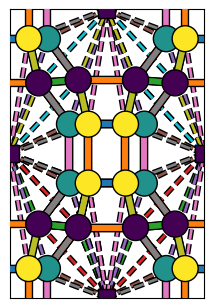

In [59]:
plt.figure(figsize=(10/4,15/4))
for i in ce_dict:
    x = 0
    for j in ce_dict[i]:
        
        x1, x2 = X[j[0]].copy(), X[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            
            line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=4, zorder=5)
            plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=6, c='black', zorder=4)
        
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=4, zorder=5)
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= 'black',lw=6, zorder=4)
        x+=1
        
        
for i in cp_dict:
    x = 0
    for j in cp_dict[i]:
        
        x1, x2 = X[j[0]].copy(), X_pore[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        #     line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        
        # plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        x+=1
        

# Xp0 = X_pore@rotation_matrix.T
# Xp10 = (X_pore+[1,0,0])@rotation_matrix.T
# Xp01 = (X_pore+[0,1,0])@rotation_matrix.T
# Xp11 = (X_pore+[1,1,0])@rotation_matrix.T
# plt.scatter(Xp0[:,0], Xp0[:,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
# plt.scatter(Xp10[:,0], Xp10[:,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
# plt.scatter(Xp01[:,0], Xp01[:,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
# plt.scatter(Xp11[:,0], Xp11[:,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([],[])
plt.yticks([],[])
plt.scatter(X[:,0], X[:,1], c=color, s=350, zorder=10, edgecolors='black')

plt.scatter(X_pore[:2,0], X_pore[:2,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:2,0]+1, X_pore[:2,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:2,0], X_pore[:2,1]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:2,0]+1, X_pore[:2,1]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
# plt.scatter(X[:,0], X[:,1], c='black', s=500, zorder=9)
plt.savefig('figures/weight_sharing_pore_itw.pdf', bbox_inches='tight', dpi=1200);
plt.savefig('figures/weight_sharing_pore_itw.png', bbox_inches='tight', dpi=1200);

In [48]:
X_pore

array([[0.5 , 0.  , 0.5 ],
       [0.  , 0.5 , 0.5 ],
       [0.5 , 0.5 , 0.  ],
       [0.5 , 0.  , 0.  ],
       [0.5 , 0.5 , 0.5 ],
       [0.5 , 0.  , 0.5 ],
       [0.5 , 0.25, 0.5 ],
       [0.5 , 0.75, 0.5 ]])

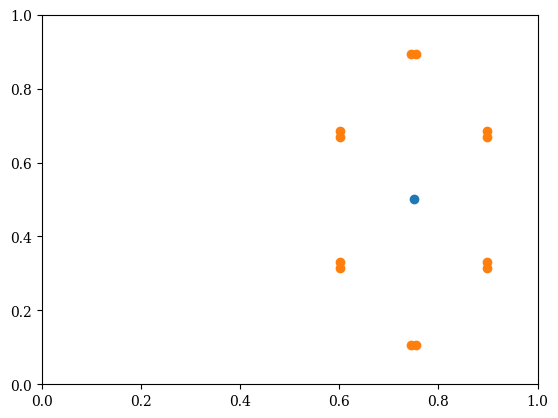

In [57]:
num = 7
plt.scatter(X_pore[num,1], X_pore[num,2])
plt.xlim(0,1)
plt.ylim(0,1)

tmp = X[A_pore[:,num]==1]
plt.scatter(tmp[:,1], tmp[:,2])


In [127]:
X

array([[0.352, 0.244, 0.894],
       [0.307, 0.398, 0.332],
       [0.404, 0.398, 0.686],
       [0.648, 0.244, 0.106],
       [0.693, 0.398, 0.668],
       [0.596, 0.398, 0.314],
       [0.648, 0.755, 0.106],
       [0.693, 0.602, 0.668],
       [0.596, 0.602, 0.314],
       [0.352, 0.755, 0.894],
       [0.307, 0.602, 0.332],
       [0.404, 0.602, 0.686],
       [0.852, 0.745, 0.894],
       [0.807, 0.898, 0.332],
       [0.904, 0.898, 0.686],
       [0.148, 0.745, 0.106],
       [0.193, 0.898, 0.668],
       [0.096, 0.898, 0.314],
       [0.148, 0.256, 0.106],
       [0.193, 0.102, 0.668],
       [0.096, 0.102, 0.314],
       [0.852, 0.256, 0.894],
       [0.807, 0.102, 0.332],
       [0.904, 0.102, 0.686]])

(0.0, 1.0)

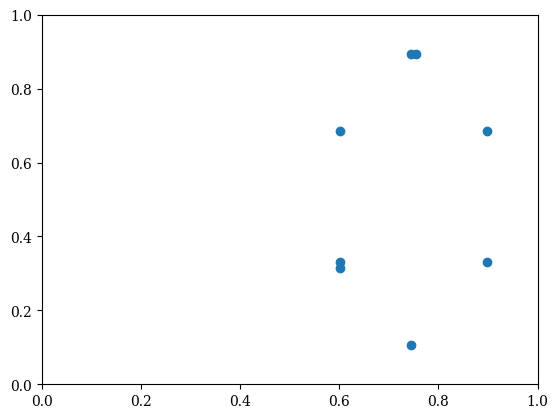